# Twitter Ratio

This folder contains data behind the story [The Worst Tweeter In Politics Isn’t Trump](https://fivethirtyeight.com/features/the-worst-tweeter-in-politics-isnt-trump/).

`senators.csv` contains tweets from all senators collected on Oct. 19 and 20.

`BarackObama.csv` contains tweets from [@BarackObama](https://twitter.com/BarackObama) collected on Oct. 20.

`realDonaldTrump.csv` contains tweets from [@realDonaldTrump](https://twitter.com/realDonaldTrump) collected on Oct. 23.

## Senator Tweets

We'll start of by looking at the `senators.csv` dataset.

In [1]:
# The usual suspects ...
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cleaner2 as clr

# And their accomplices ...
from gensim import corpora
from gensim import models
from gensim import similarities
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from collections import defaultdict

# Settings
sns.set(context='notebook', style='whitegrid', palette='deep', rc=None)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# Reading in the data
tweets = pd.read_csv('senators.csv', encoding="ISO-8859-1")
tweets.shape

(288615, 10)

In [3]:
# Top 5 rows
tweets.head()

,created_at,text,url,replies,retweets,favorites,user,bioguide_id,party,state
0,10/19/17 21:47,We released bipartisan healthcare bill today &...,https://twitter.com/amyklobuchar/status/921130...,21,129,533,amyklobuchar,K000367,D,MN
1,10/19/17 18:48,I spoke with @Morning_Joe team abt #HonestAds ...,https://twitter.com/amyklobuchar/status/921085...,8,46,150,amyklobuchar,K000367,D,MN
2,10/19/17 18:14,Lots of interest in my bill with Senators Warn...,https://twitter.com/amyklobuchar/status/921077...,36,227,932,amyklobuchar,K000367,D,MN
3,10/19/17 18:04,"Today's the day @MarkWarner, @SenJohnMcCain &a...",https://twitter.com/amyklobuchar/status/921074...,17,167,550,amyklobuchar,K000367,D,MN
4,10/19/17 16:33,".@MarkWarner, @SenJohnMcCain &amp; I put toget...",https://twitter.com/amyklobuchar/status/921051...,31,279,893,amyklobuchar,K000367,D,MN


### Exploration

In [4]:
tweets.dtypes

created_at     object
text           object
url            object
replies         int64
retweets        int64
favorites       int64
user           object
bioguide_id    object
party          object
state          object
dtype: object

Text(0,0.5,'Density')

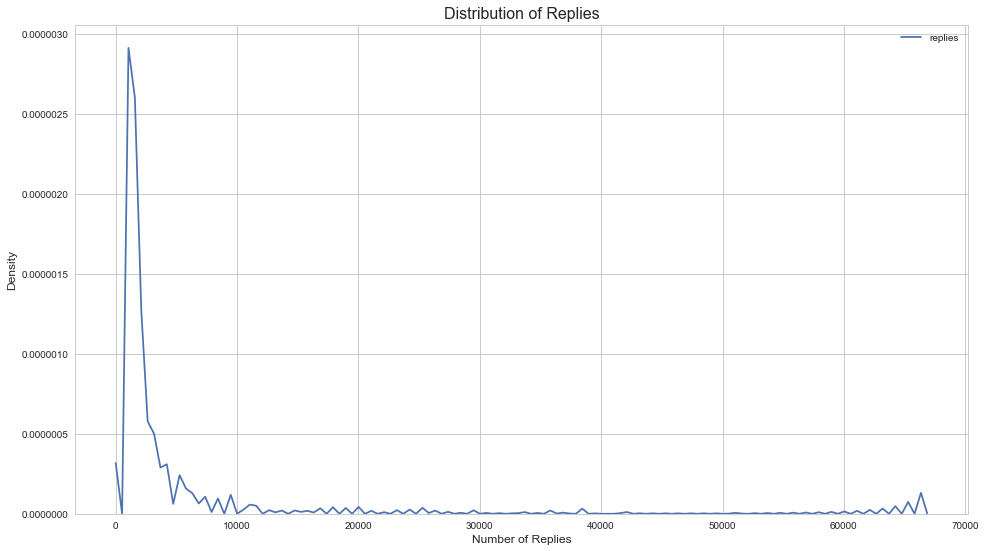

In [5]:
# Distribution of replies
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.replies)
plt.title('Distribution of Replies', fontsize=16)
plt.xlabel('Number of Replies', fontsize=12)
plt.ylabel('Density', fontsize=12)

Text(0,0.5,'Density')

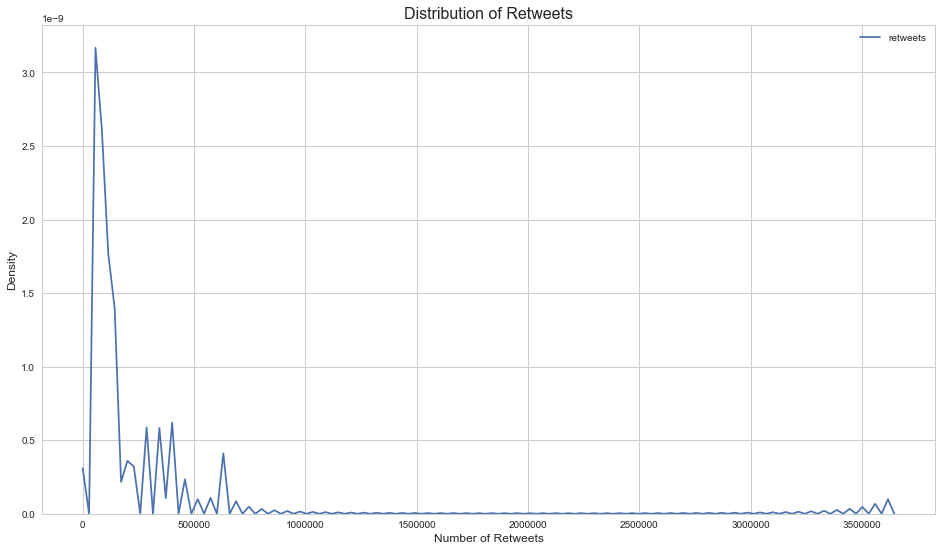

In [6]:
# Distribution of retweets
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.retweets)
plt.title('Distribution of Retweets', fontsize=16)
plt.xlabel('Number of Retweets', fontsize=12)
plt.ylabel('Density', fontsize=12)

Text(0,0.5,'Density')

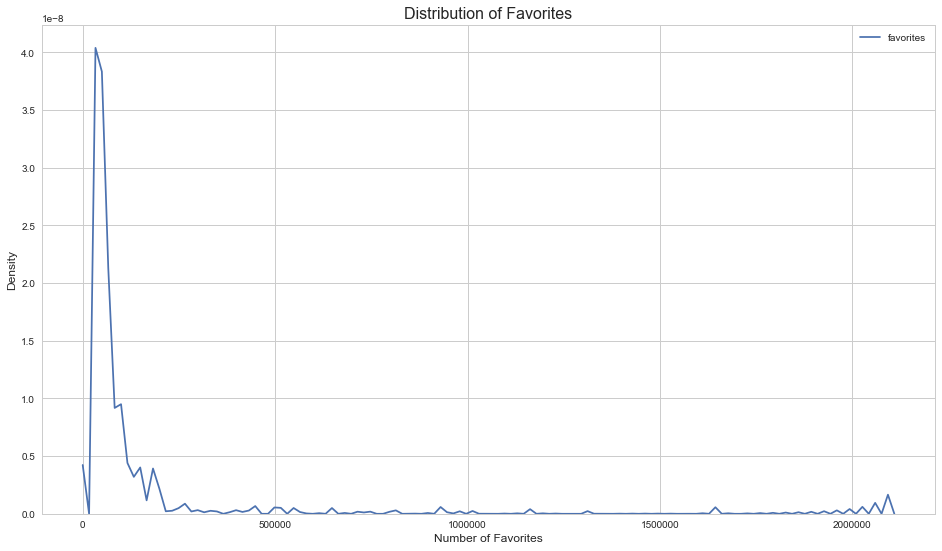

In [7]:
# Distribution of favourites
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.favorites)
plt.title('Distribution of Favorites', fontsize=16)
plt.xlabel('Number of Favorites', fontsize=12)
plt.ylabel('Density', fontsize=12)

Text(0,0.5,'Retweets')

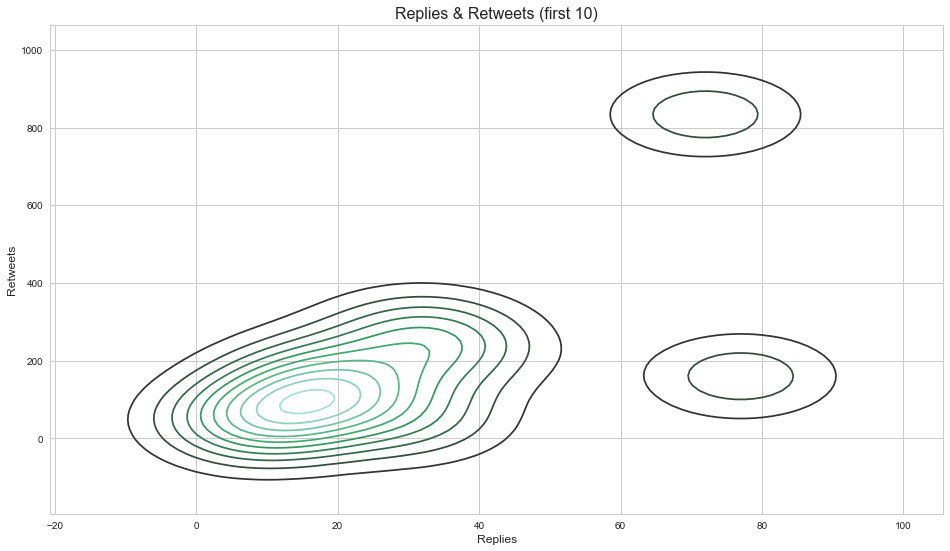

In [8]:
# Replies-Retweets
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.replies[:10].dropna(), tweets.retweets[:10].dropna())
plt.title('Replies & Retweets (first 10)', fontsize=16)
plt.xlabel('Replies', fontsize=12)
plt.ylabel('Retweets', fontsize=12)

Text(0,0.5,'Retweets')

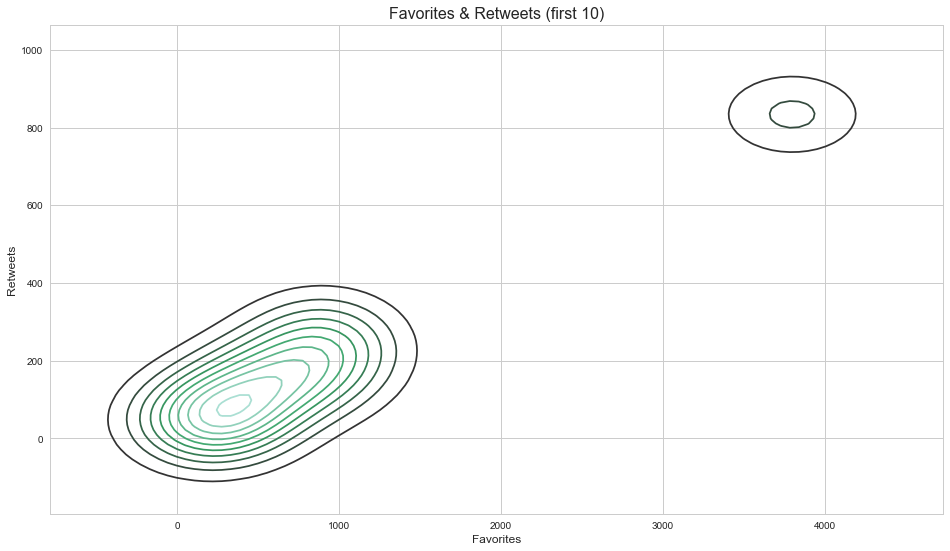

In [9]:
# Favourites-Retweets
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.favorites[:10].dropna(), tweets.retweets[:10].dropna())
plt.title('Favorites & Retweets (first 10)', fontsize=16)
plt.xlabel('Favorites', fontsize=12)
plt.ylabel('Retweets', fontsize=12)

Text(0,0.5,'Favorites')

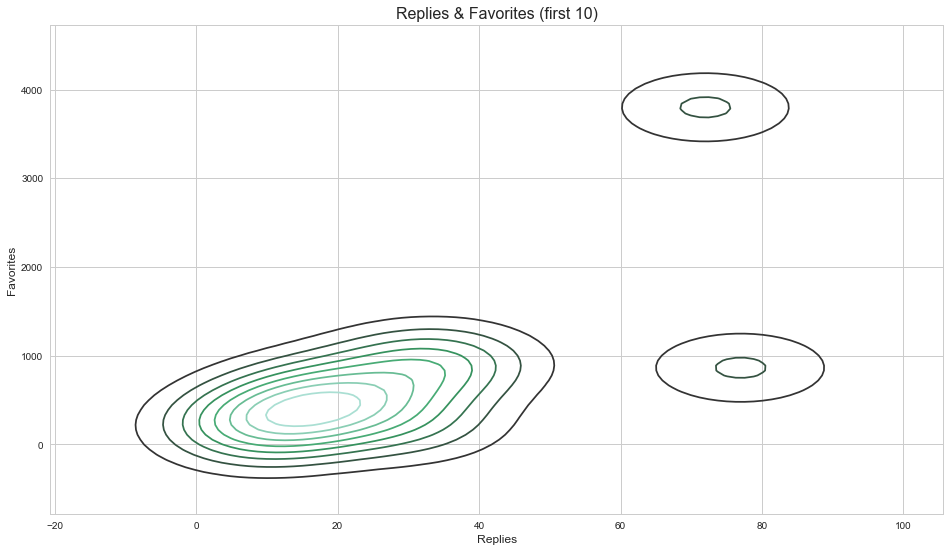

In [10]:
# Replies-Favorites
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.replies[:10].dropna(), tweets.favorites[:10].dropna())
plt.title('Replies & Favorites (first 10)', fontsize=16)
plt.xlabel('Replies', fontsize=12)
plt.ylabel('Favorites', fontsize=12)

Text(0.5,0,'Count')

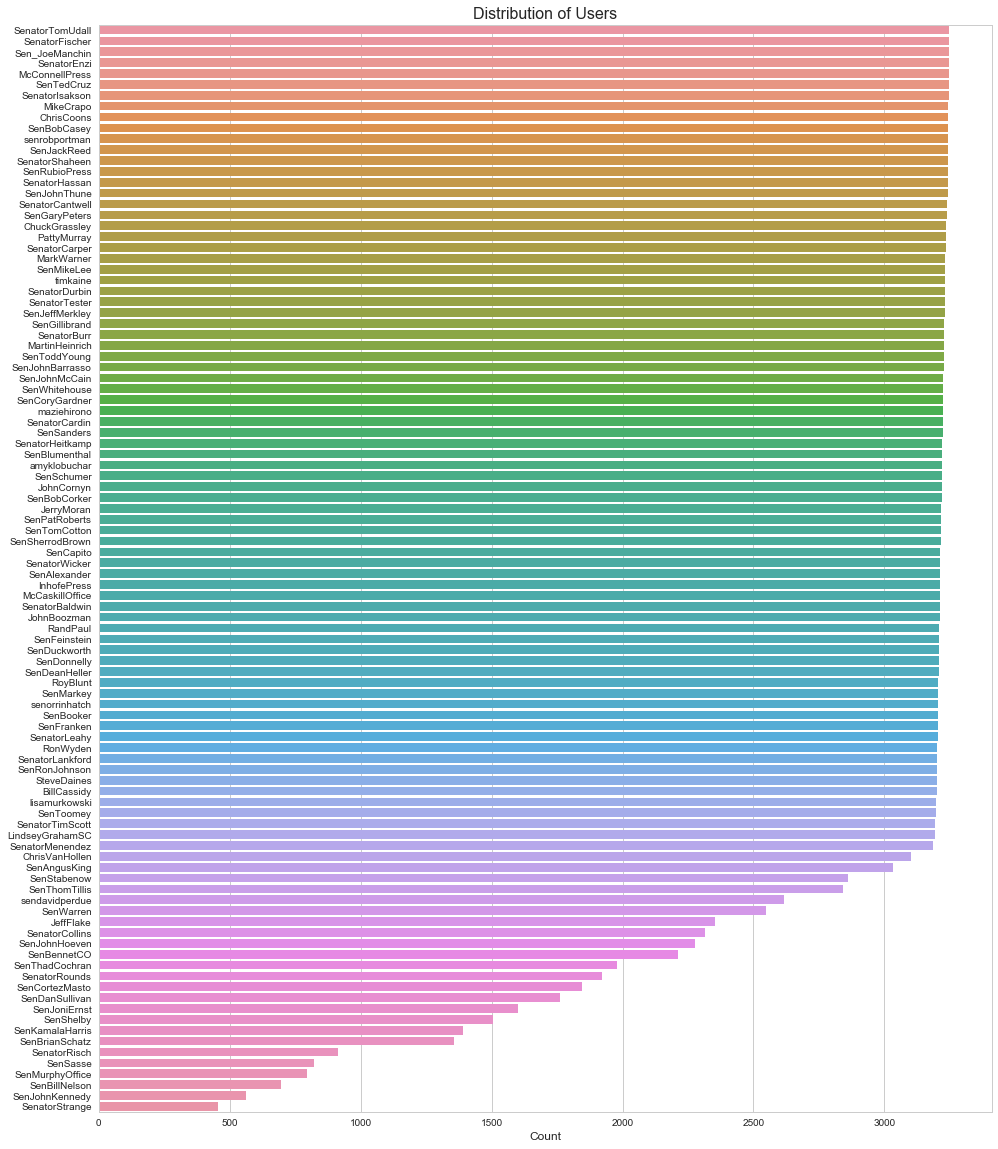

In [11]:
# Distribution of users
plt.figure(figsize=(16, 20))
sns.countplot(y=tweets.user, order=tweets.user.value_counts().index)
plt.title('Distribution of Users', fontsize=16)
plt.ylabel('')
plt.xlabel('Count', fontsize=12)

Text(0.5,0,'Replies')

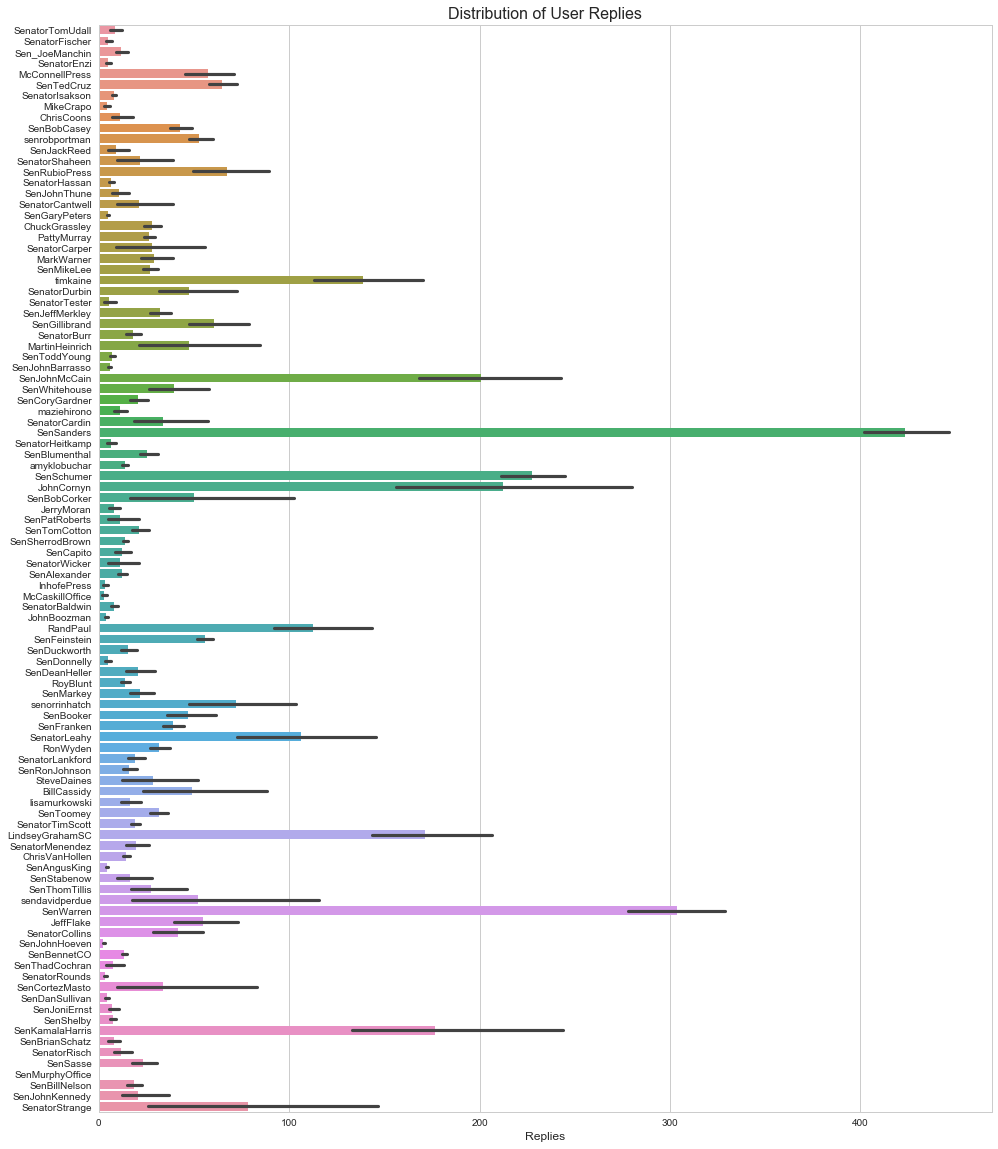

In [12]:
# Distribution of user replies
plt.figure(figsize=(16, 20))
sns.barplot(x=tweets.replies, y=tweets.user, order=tweets.user.value_counts().index)
plt.title('Distribution of User Replies', fontsize=16)
plt.ylabel('')
plt.xlabel('Replies', fontsize=12)

Text(124,0.5,'')

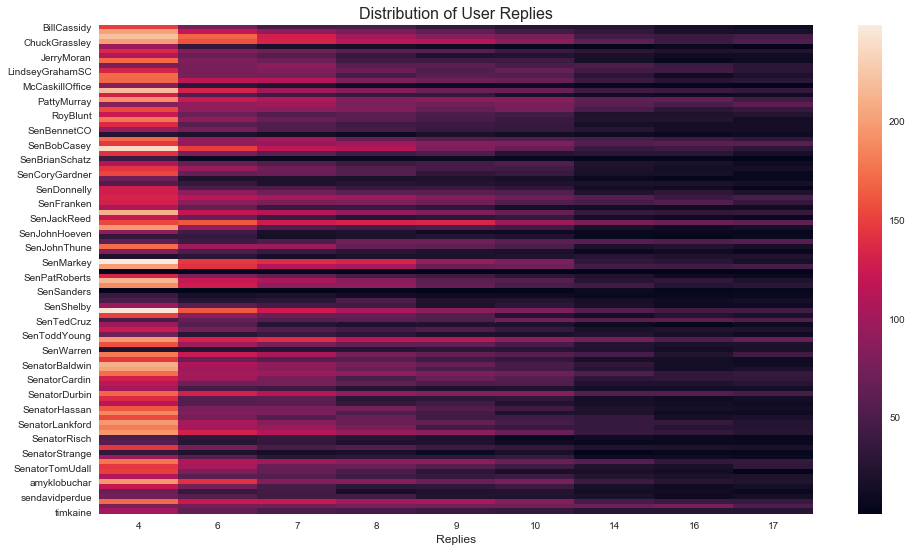

In [13]:
# Distribution of user replies
a = tweets.groupby(['user', 'replies'])['user'].count().unstack('replies').dropna(axis=1, how='any')
plt.figure(figsize=(16, 9))
sns.heatmap(a)
plt.title('Distribution of User Replies', fontsize=16)
plt.xlabel('Replies', fontsize=12)
plt.ylabel('')

Text(124,0.5,'')

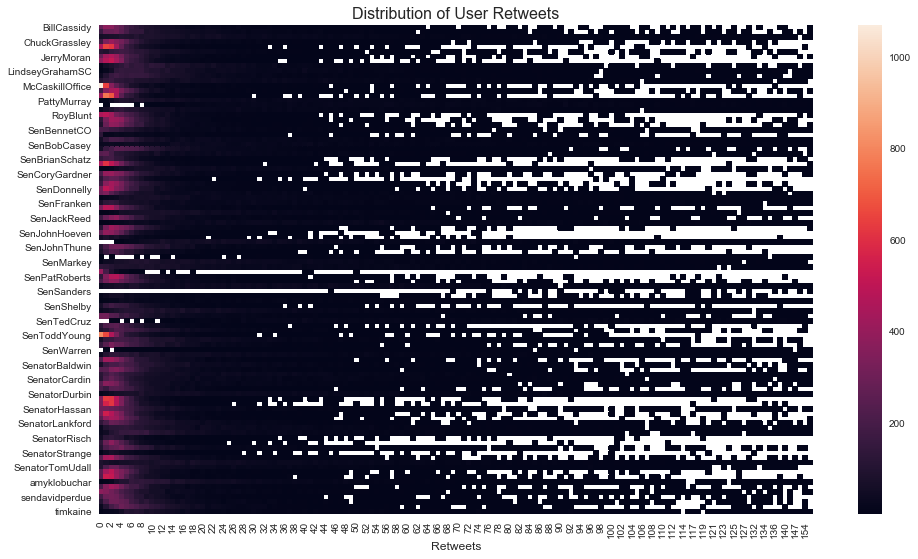

In [14]:
# Distribution of user retweets
a = tweets.groupby(['user', 'retweets'])['user'].count().unstack('retweets').dropna(axis=1, how='all')

# Cleaning the matrix
_removeColumn = list()
for column in a.columns:
    # 1. Number of unique items the columns contains:
    if (len(a[column].unique()) == 1):
        _removeColumn.append(column)
        # 2. Number of missing values:
    elif (a[column].isnull().sum() > ((a.shape[0])/2)):
        _removeColumn.append(column)

# Removing the columns
deleteColumn = (x for x in _removeColumn)
try:
    while True:
        del a[deleteColumn.__next__()]
except StopIteration:
    pass

# Plotting
plt.figure(figsize=(16, 9))
sns.heatmap(a)
plt.title('Distribution of User Retweets', fontsize=16)
plt.xlabel('Retweets', fontsize=12)
plt.ylabel('')

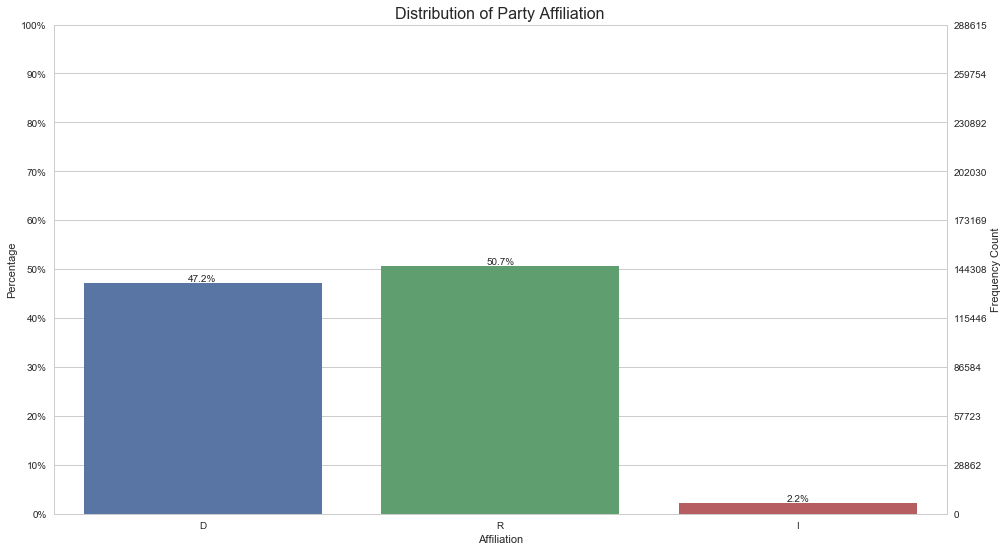

In [15]:
# Distribution of party affiliations
clr.frequency_plot(dataframe=tweets, 
                   x='party',
                   title='Distribution of Party Affiliation',
                   xlabel='Affiliation')

Text(0,0.5,'Count')

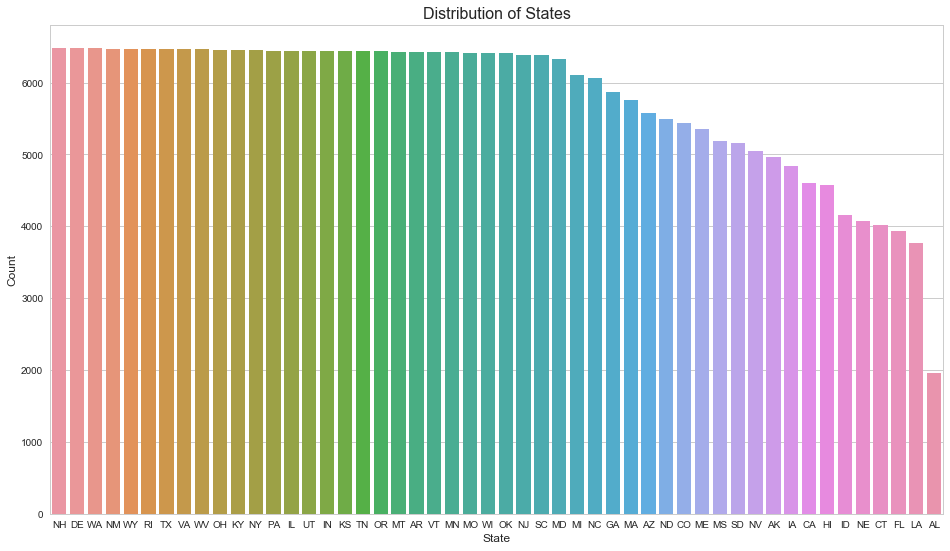

In [16]:
# Distribution of states
sns.countplot(tweets.state, order=tweets.state.value_counts().index)
plt.title('Distribution of States', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Count', fontsize=12)

(array([  0.5,   2.5,   4.5,   6.5,   8.5,  10.5,  12.5,  14.5,  16.5,
         18.5,  20.5,  22.5,  24.5,  26.5,  28.5,  30.5,  32.5,  34.5,
         36.5,  38.5,  40.5,  42.5,  44.5,  46.5,  48.5]),
 <a list of 25 Text yticklabel objects>)

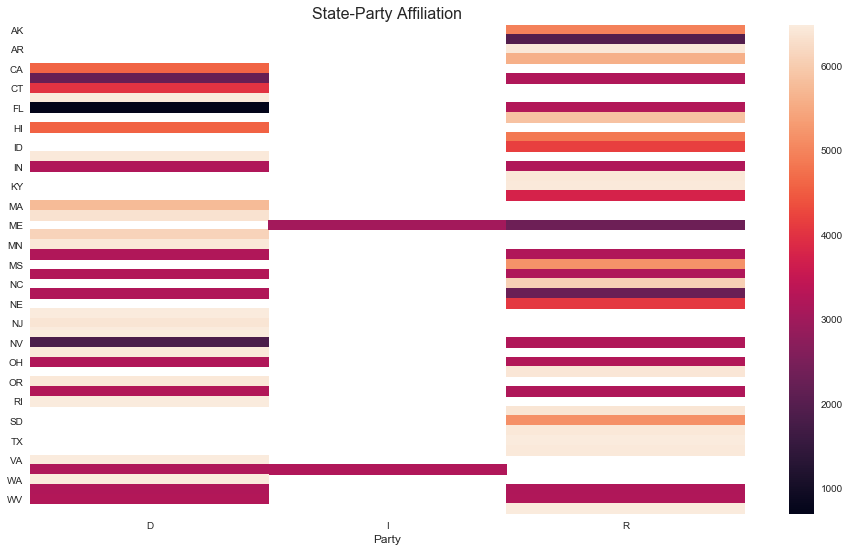

In [17]:
# State-Party
a = tweets.groupby(['state', 'party'])['state'].count().unstack('party')
sns.heatmap(a)
plt.title('State-Party Affiliation', fontsize=16)
plt.xlabel('Party', fontsize=12)
plt.ylabel('')
plt.yticks(rotation=0)

(array([  0.5,   2.5,   4.5,   6.5,   8.5,  10.5,  12.5,  14.5,  16.5,
         18.5,  20.5,  22.5,  24.5,  26.5,  28.5,  30.5,  32.5,  34.5,
         36.5,  38.5,  40.5,  42.5,  44.5,  46.5,  48.5]),
 <a list of 25 Text yticklabel objects>)

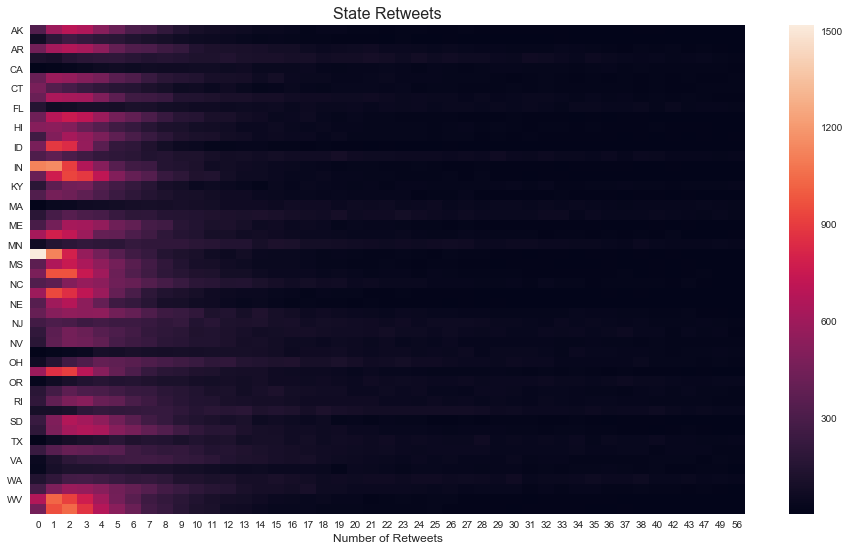

In [18]:
# State-Retweets
a = tweets.groupby(['state', 'retweets'])['retweets'].count().unstack('retweets').dropna(axis=1, how='any')
sns.heatmap(a)
plt.title('State Retweets', fontsize=16)
plt.xlabel('Number of Retweets', fontsize=12)
plt.ylabel('')
plt.yticks(rotation=0)

(array([  0.5,   2.5,   4.5,   6.5,   8.5,  10.5,  12.5,  14.5,  16.5,
         18.5,  20.5,  22.5,  24.5,  26.5,  28.5,  30.5,  32.5,  34.5,
         36.5,  38.5,  40.5,  42.5,  44.5,  46.5,  48.5]),
 <a list of 25 Text yticklabel objects>)

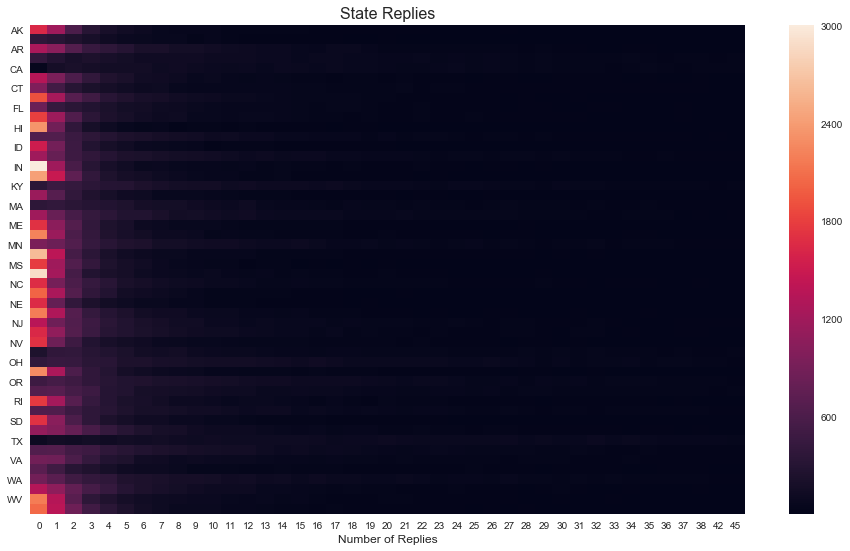

In [19]:
# State-Replies
a = tweets.groupby(['state', 'replies'])['replies'].count().unstack('replies').dropna(axis=1, how='any')
sns.heatmap(a)
plt.title('State Replies', fontsize=16)
plt.xlabel('Number of Replies', fontsize=12)
plt.ylabel('')
plt.yticks(rotation=0)

### Time Series

In [20]:
# Converting 'created_at' to datetime format
tweets['created_at'] = pd.to_datetime(tweets['created_at'], yearfirst=True, exact=False)

# Subsetting
tweets_subset = tweets.loc[(tweets['created_at'].dt.year > 2015)]
tweets_subset = tweets_subset.sort_values(by='created_at')

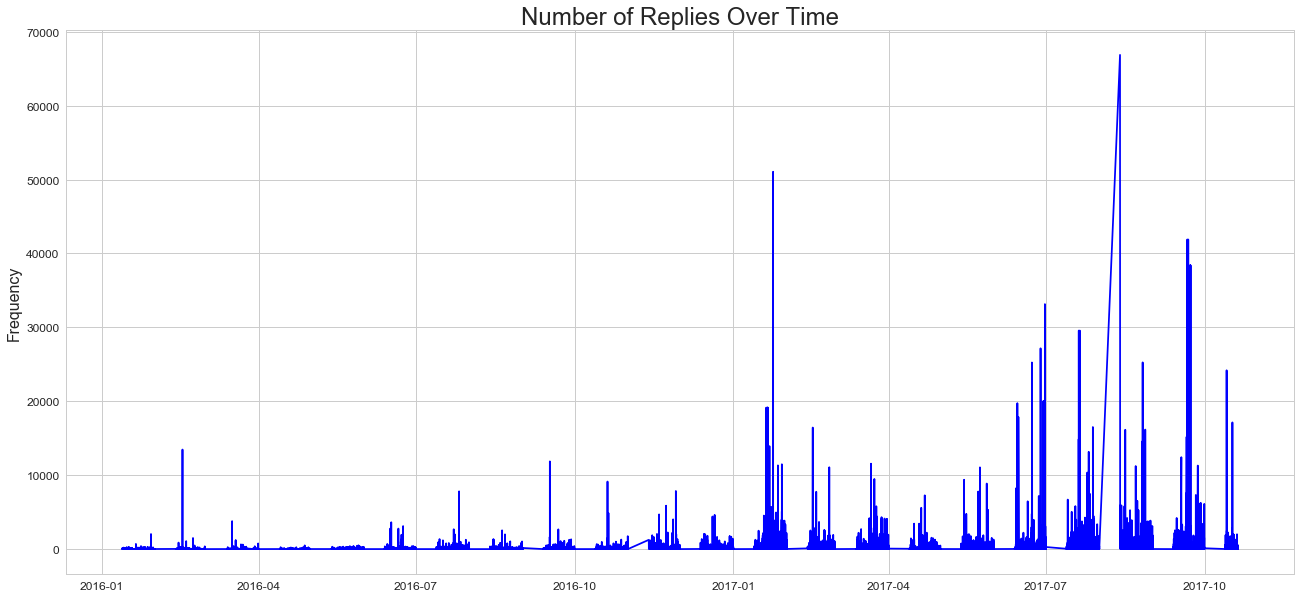

In [21]:
# Plotting function
def plot_series(series, title=None, color='blue'):
    plt.figure(figsize=(22, 10))
    plt.plot(series, color=color)
    plt.title(title, fontsize=24)
    plt.xticks(fontsize=12)
    plt.ylabel('Frequency', fontsize=16)
    plt.yticks(fontsize=12)

# Creating the tweet replies series
s = tweets_subset[['created_at', 'replies']]
replies = s.set_index('created_at')['replies']

# Number of tweet replies over time
plot_series(replies, title='Number of Replies Over Time')

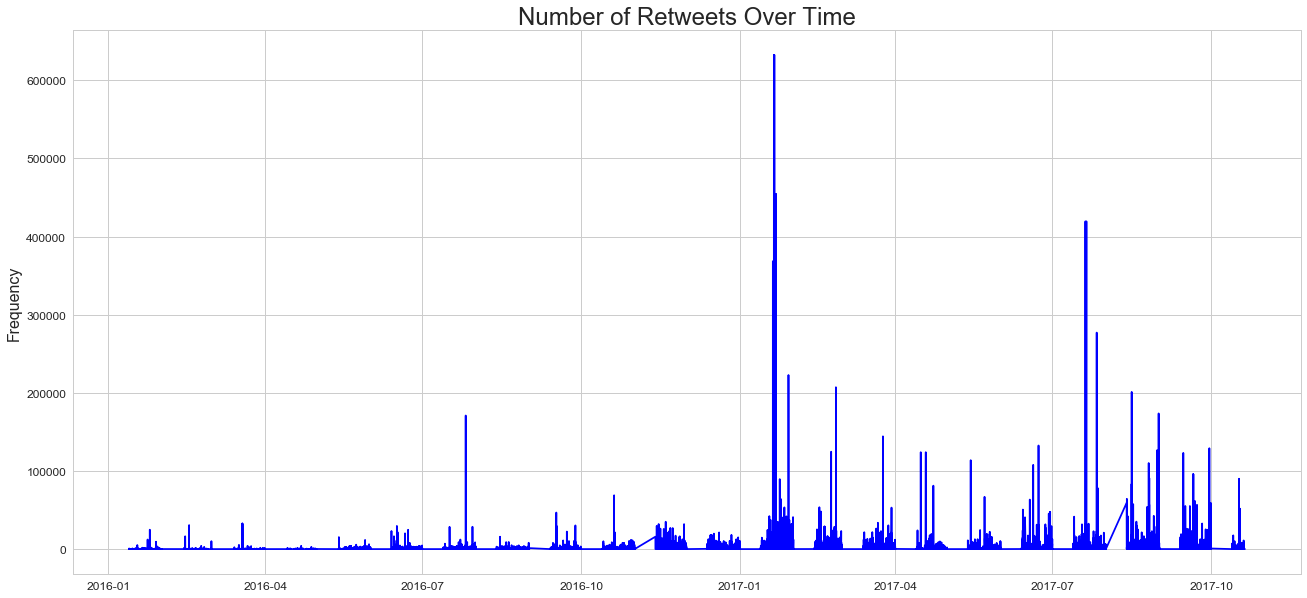

In [22]:
# Creating the retweet series
s = tweets_subset[['created_at', 'retweets']]
retweets = s.set_index('created_at')['retweets']

# Number of retweets over time
plot_series(retweets, title='Number of Retweets Over Time')

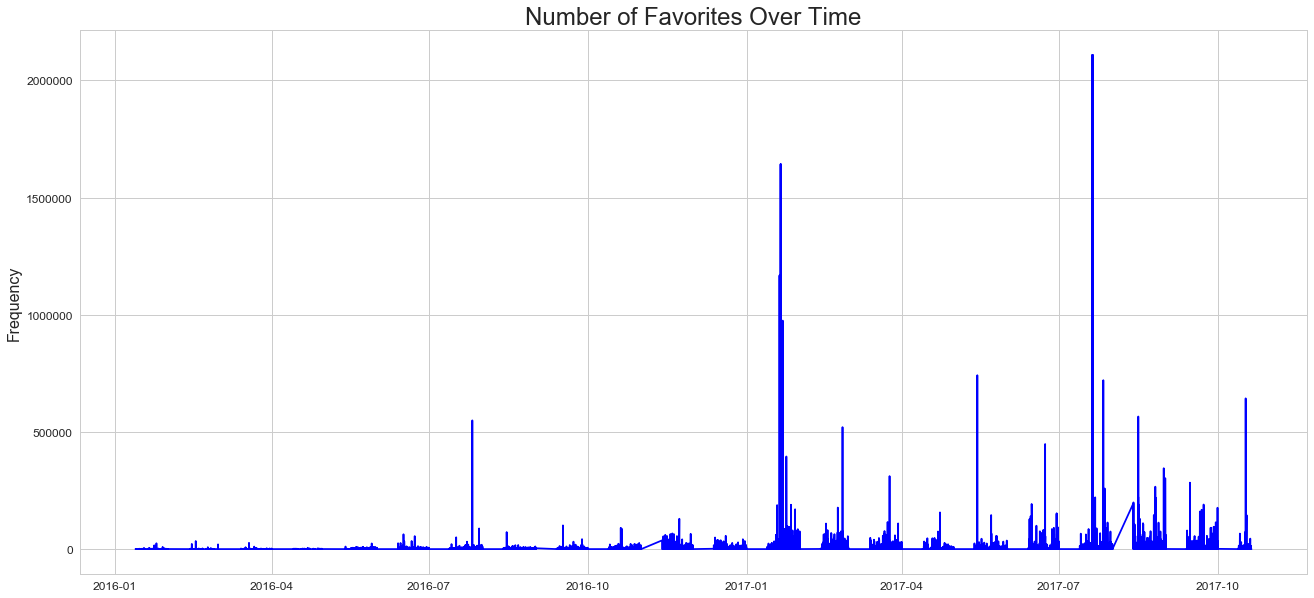

In [23]:
# Creating the favorites series
s = tweets_subset[['created_at', 'favorites']]
favorites = s.set_index('created_at')['favorites']

# Number of retweets over time
plot_series(favorites, title='Number of Favorites Over Time')

### Text Analysis

In [24]:
# Text corpus
document = [i for i in tweets.text]

# Removing common words and tokenizing
stop_words = set(stopwords.words('english'))
update_words = ['-', '=', '+', '*','.', ',', '"', "'", '?', '!', 'w/',
                ':', ';', 'heäó»ll', "i'd", '(and', "there's", '(', 
                ')', '[', ']', '{', '}', '&amp', '&amp;', '&', '$', 
                '^', '.*', '*.', 'äóìbest', 'adäó_', 'staäó_', "i'll",
                'worldäó_', 'hereäó»s', 'letäó»s', 'adminäó»s', '(who', 
                'haveäó_', 'äóñ', '--', '---', 'träó_', 'americaäó»s', 
                'andäó_', 'foräó_', 'cräó_', 'asäó_', 'täó_', 'wäó_', 
                'toäó_', "it'll", "i've", 'iäó»ll', 'here:', ':here',
                'https:äó_', 'httpsäó_']
stop_words.update(update_words)
for doc in document:
    list_of_words = [i.lower() for i in wordpunct_tokenize(doc) if i.lower() not in stop_words]
stop_words.update(list_of_words)

# Removing common words
texts = [[word for word in doc.lower().split() if word not in stop_words] for doc in document]

# Removing words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > 7] for text in texts]

# Create dictionary of the document
dictionary = corpora.Dictionary(texts)
dictionary.save('senator.dict')

# Converting document to a vector (bag-of-words)
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('senator.mm', corpus)

# Print done
print('Done!')

2018-07-02 15:38:35,067 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-07-02 15:38:35,230 : INFO : adding document #10000 to Dictionary(13530 unique tokens: ['bill', 'bipartisan', 'done.', 'get', 'healthcare']...)
2018-07-02 15:38:35,393 : INFO : adding document #20000 to Dictionary(18522 unique tokens: ['bill', 'bipartisan', 'done.', 'get', 'healthcare']...)
2018-07-02 15:38:35,557 : INFO : adding document #30000 to Dictionary(21456 unique tokens: ['bill', 'bipartisan', 'done.', 'get', 'healthcare']...)
2018-07-02 15:38:35,726 : INFO : adding document #40000 to Dictionary(23450 unique tokens: ['bill', 'bipartisan', 'done.', 'get', 'healthcare']...)
2018-07-02 15:38:35,887 : INFO : adding document #50000 to Dictionary(25040 unique tokens: ['bill', 'bipartisan', 'done.', 'get', 'healthcare']...)
2018-07-02 15:38:36,052 : INFO : adding document #60000 to Dictionary(26014 unique tokens: ['bill', 'bipartisan', 'done.', 'get', 'healthcare']...)
2018-07-02 15:38:36,220 :

2018-07-02 15:38:49,657 : INFO : PROGRESS: saving document #53000
2018-07-02 15:38:49,676 : INFO : PROGRESS: saving document #54000
2018-07-02 15:38:49,693 : INFO : PROGRESS: saving document #55000
2018-07-02 15:38:49,711 : INFO : PROGRESS: saving document #56000
2018-07-02 15:38:49,733 : INFO : PROGRESS: saving document #57000
2018-07-02 15:38:49,753 : INFO : PROGRESS: saving document #58000
2018-07-02 15:38:49,783 : INFO : PROGRESS: saving document #59000
2018-07-02 15:38:49,801 : INFO : PROGRESS: saving document #60000
2018-07-02 15:38:49,821 : INFO : PROGRESS: saving document #61000
2018-07-02 15:38:49,850 : INFO : PROGRESS: saving document #62000
2018-07-02 15:38:49,868 : INFO : PROGRESS: saving document #63000
2018-07-02 15:38:49,885 : INFO : PROGRESS: saving document #64000
2018-07-02 15:38:49,911 : INFO : PROGRESS: saving document #65000
2018-07-02 15:38:49,930 : INFO : PROGRESS: saving document #66000
2018-07-02 15:38:49,949 : INFO : PROGRESS: saving document #67000
2018-07-02

2018-07-02 15:38:53,580 : INFO : PROGRESS: saving document #176000
2018-07-02 15:38:53,599 : INFO : PROGRESS: saving document #177000
2018-07-02 15:38:53,617 : INFO : PROGRESS: saving document #178000
2018-07-02 15:38:53,633 : INFO : PROGRESS: saving document #179000
2018-07-02 15:38:54,235 : INFO : PROGRESS: saving document #180000
2018-07-02 15:38:54,255 : INFO : PROGRESS: saving document #181000
2018-07-02 15:38:54,274 : INFO : PROGRESS: saving document #182000
2018-07-02 15:38:54,294 : INFO : PROGRESS: saving document #183000
2018-07-02 15:38:54,313 : INFO : PROGRESS: saving document #184000
2018-07-02 15:38:54,332 : INFO : PROGRESS: saving document #185000
2018-07-02 15:38:54,351 : INFO : PROGRESS: saving document #186000
2018-07-02 15:38:54,371 : INFO : PROGRESS: saving document #187000
2018-07-02 15:38:54,392 : INFO : PROGRESS: saving document #188000
2018-07-02 15:38:54,453 : INFO : PROGRESS: saving document #189000
2018-07-02 15:38:54,473 : INFO : PROGRESS: saving document #19

Done!


***
#### Transformation: _Term Frequency - Inverse Document Frequency (TF-IDF)_

**tf-idf** is initialized with a **bag-of-words** (integer values) training corpus and takes in a vector, returning another vector of the same dimensionality. except that features which are rare in the training corpus will have their value increased. It therefore converts integer-valued vectors into real-valued ones, while leaving the number of dimensions intact. It can also, optionally, normalize the resulting vectors to (Euclidean) unit length.

##### Step 1:

In [25]:
# Initialization
tfidf = models.TfidfModel(corpus)

2018-07-02 15:39:10,557 : INFO : collecting document frequencies
2018-07-02 15:39:10,557 : INFO : PROGRESS: processing document #0
2018-07-02 15:39:10,595 : INFO : PROGRESS: processing document #10000
2018-07-02 15:39:10,630 : INFO : PROGRESS: processing document #20000
2018-07-02 15:39:10,664 : INFO : PROGRESS: processing document #30000
2018-07-02 15:39:10,698 : INFO : PROGRESS: processing document #40000
2018-07-02 15:39:10,728 : INFO : PROGRESS: processing document #50000
2018-07-02 15:39:10,761 : INFO : PROGRESS: processing document #60000
2018-07-02 15:39:10,796 : INFO : PROGRESS: processing document #70000
2018-07-02 15:39:10,828 : INFO : PROGRESS: processing document #80000
2018-07-02 15:39:10,859 : INFO : PROGRESS: processing document #90000
2018-07-02 15:39:10,893 : INFO : PROGRESS: processing document #100000
2018-07-02 15:39:10,925 : INFO : PROGRESS: processing document #110000
2018-07-02 15:39:10,959 : INFO : PROGRESS: processing document #120000
2018-07-02 15:39:10,993 : 

##### Step 2:

In [26]:
# Applying the transformation to the whole corpus
corpus_tfidf = tfidf[corpus]

#### Transformation: _Latent Semantic Indexing (LSI, or sometimes LSA)_

Transforms documents from either **bag-of-words** or (preferably) **tf-idf**-weighted space into a latent space of a lower dimensionality. 

**LSI** is unique in that we can continue "training" at any point, simply by providing more training documents. This is done by incremental updates to the underlying model, in a process called _online training_. Because of this feature, the input document stream may even be infinite - just keep feeding **LSI** new documents as they arrive, while using the computed transformation model as read-only in the meanwhile!

[gensim.models.lsimodel](https://radimrehurek.com/gensim/models/lsimodel.html#module-gensim.models.lsimodel) contains details for making an **LSI** model gradually "forget" old observations in infinite streams, with parameters that can be tweaked to affect speed, memory footprint and numerical precision of the **LSI** algorithm.

[___gensim___](https://radimrehurek.com/gensim) uses a novel online incremental streamed distributed training algorithm published [here](https://radimrehurek.com/gensim/tut2.html#id10). ___gensim___ also executes a stochastic multi-pass algorithm from [Halko et al.](https://radimrehurek.com/gensim/tut2.html#id9) internally, to accelerate in-core part of the computations.

In [27]:
# Initializing an LSI transformation
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=50)
corpus_lsi = lsi[corpus_tfidf]

2018-07-02 15:39:11,578 : INFO : using serial LSI version on this node
2018-07-02 15:39:11,579 : INFO : updating model with new documents
2018-07-02 15:39:12,688 : INFO : preparing a new chunk of documents
2018-07-02 15:39:12,794 : INFO : using 100 extra samples and 2 power iterations
2018-07-02 15:39:12,795 : INFO : 1st phase: constructing (30487, 150) action matrix
2018-07-02 15:39:12,963 : INFO : orthonormalizing (30487, 150) action matrix
2018-07-02 15:39:13,780 : INFO : 2nd phase: running dense svd on (150, 20000) matrix
2018-07-02 15:39:13,990 : INFO : computing the final decomposition
2018-07-02 15:39:13,991 : INFO : keeping 50 factors (discarding 44.694% of energy spectrum)
2018-07-02 15:39:14,016 : INFO : processed documents up to #20000
2018-07-02 15:39:14,041 : INFO : topic #0(10.104): 0.731*"inhofe" + 0.273*"sen." + 0.233*"w" + 0.132*"rt" + 0.111*"iowa" + 0.110*"#lasen" + 0.093*"good" + 0.088*"senate" + 0.088*"bill" + 0.084*"great"
2018-07-02 15:39:14,043 : INFO : topic #1(

2018-07-02 15:39:22,904 : INFO : topic #0(18.862): 0.340*"rt" + 0.178*"senate" + 0.166*"great" + 0.159*"health" + 0.150*"bill" + 0.150*"today" + 0.136*"thank" + 0.130*"care" + 0.128*"thanks" + 0.128*"work"
2018-07-02 15:39:22,906 : INFO : topic #1(13.336): -0.369*"great" + -0.324*"thanks" + -0.319*"thank" + 0.300*"health" + 0.271*"senate" + 0.248*"care" + 0.177*"bill" + 0.153*"mcconnell" + -0.139*"happy" + 0.120*"floor"
2018-07-02 15:39:22,908 : INFO : topic #2(13.089): -0.379*"rt" + 0.363*"health" + 0.306*"care" + -0.231*"sen." + -0.170*"mcconnell" + -0.170*"senate" + -0.152*"live" + 0.150*"work" + -0.148*"watch" + -0.135*"tune"
2018-07-02 15:39:22,910 : INFO : topic #3(12.477): -0.584*"rt" + 0.235*"mcconnell" + 0.229*".@senatemajldr" + 0.222*"great" + 0.213*"senate" + 0.147*"tune" + -0.144*"thank" + 0.140*"#kentucky" + -0.133*"health" + 0.127*"today"
2018-07-02 15:39:22,912 : INFO : topic #4(12.081): 0.486*"mcconnell" + 0.414*".@senatemajldr" + -0.286*"tune" + 0.265*"#kentucky" + -0.

2018-07-02 15:39:31,719 : INFO : topic #4(15.719): -0.396*"health" + -0.330*"care" + -0.322*"rt" + 0.191*"bill" + -0.190*"great" + 0.183*"proud" + 0.183*"help" + -0.176*"tune" + -0.172*"live" + -0.150*"thanks"
2018-07-02 15:39:33,276 : INFO : preparing a new chunk of documents
2018-07-02 15:39:33,391 : INFO : using 100 extra samples and 2 power iterations
2018-07-02 15:39:33,392 : INFO : 1st phase: constructing (30487, 150) action matrix
2018-07-02 15:39:33,561 : INFO : orthonormalizing (30487, 150) action matrix
2018-07-02 15:39:34,029 : INFO : 2nd phase: running dense svd on (150, 20000) matrix
2018-07-02 15:39:34,182 : INFO : computing the final decomposition
2018-07-02 15:39:34,183 : INFO : keeping 50 factors (discarding 49.010% of energy spectrum)
2018-07-02 15:39:34,205 : INFO : merging projections: (30487, 50) + (30487, 50)
2018-07-02 15:39:34,272 : INFO : keeping 50 factors (discarding 11.620% of energy spectrum)
2018-07-02 15:39:34,299 : INFO : processed documents up to #20000

2018-07-02 15:39:43,038 : INFO : keeping 50 factors (discarding 9.753% of energy spectrum)
2018-07-02 15:39:43,067 : INFO : processed documents up to #280000
2018-07-02 15:39:43,069 : INFO : topic #0(30.986): 0.295*"rt" + 0.209*"great" + 0.187*"senate" + 0.176*"today" + 0.176*"health" + 0.171*"bill" + 0.150*"care" + 0.130*"thanks" + 0.128*"thank" + 0.127*"help"
2018-07-02 15:39:43,071 : INFO : topic #1(22.727): -0.525*"great" + 0.338*"health" + 0.299*"care" + -0.261*"thanks" + 0.208*"bill" + 0.196*"senate" + -0.181*"thank" + -0.148*"meeting" + -0.131*"happy" + -0.112*"today"
2018-07-02 15:39:43,073 : INFO : topic #2(21.273): 0.365*"health" + 0.326*"care" + -0.323*"senate" + -0.318*"watch" + -0.258*"live" + -0.241*"rt" + -0.205*"floor" + 0.189*"great" + -0.189*"tune" + -0.165*"hearing"
2018-07-02 15:39:43,075 : INFO : topic #3(20.119): -0.495*"rt" + 0.374*"great" + -0.353*"thank" + 0.202*"health" + 0.198*"senate" + -0.192*"happy" + 0.179*"watch" + 0.171*"care" + 0.151*"live" + 0.145*"tu

In [28]:
lsi.print_topics(10)

2018-07-02 15:39:44,422 : INFO : topic #0(31.495): 0.305*"rt" + 0.210*"great" + 0.185*"senate" + 0.176*"health" + 0.174*"today" + 0.169*"bill" + 0.151*"care" + 0.132*"thanks" + 0.131*"thank" + 0.125*"help"
2018-07-02 15:39:44,424 : INFO : topic #1(23.091): -0.522*"great" + 0.347*"health" + 0.307*"care" + -0.260*"thanks" + 0.206*"bill" + 0.190*"senate" + -0.184*"thank" + -0.147*"meeting" + -0.128*"happy" + -0.110*"today"
2018-07-02 15:39:44,425 : INFO : topic #2(21.572): 0.368*"health" + 0.328*"care" + -0.310*"senate" + -0.303*"watch" + -0.286*"rt" + -0.247*"live" + 0.227*"great" + -0.197*"floor" + -0.178*"tune" + -0.156*"hearing"
2018-07-02 15:39:44,427 : INFO : topic #3(20.512): -0.519*"rt" + -0.370*"thank" + 0.356*"great" + 0.234*"senate" + 0.192*"watch" + -0.180*"happy" + 0.160*"live" + 0.150*"tune" + 0.147*"floor" + 0.139*"health"
2018-07-02 15:39:44,429 : INFO : topic #4(19.645): -0.458*"rt" + -0.366*"health" + -0.309*"care" + 0.193*"help" + 0.181*"senate" + -0.179*"thanks" + 0.16

[(0,
  '0.305*"rt" + 0.210*"great" + 0.185*"senate" + 0.176*"health" + 0.174*"today" + 0.169*"bill" + 0.151*"care" + 0.132*"thanks" + 0.131*"thank" + 0.125*"help"'),
 (1,
  '-0.522*"great" + 0.347*"health" + 0.307*"care" + -0.260*"thanks" + 0.206*"bill" + 0.190*"senate" + -0.184*"thank" + -0.147*"meeting" + -0.128*"happy" + -0.110*"today"'),
 (2,
  '0.368*"health" + 0.328*"care" + -0.310*"senate" + -0.303*"watch" + -0.286*"rt" + -0.247*"live" + 0.227*"great" + -0.197*"floor" + -0.178*"tune" + -0.156*"hearing"'),
 (3,
  '-0.519*"rt" + -0.370*"thank" + 0.356*"great" + 0.234*"senate" + 0.192*"watch" + -0.180*"happy" + 0.160*"live" + 0.150*"tune" + 0.147*"floor" + 0.139*"health"'),
 (4,
  '-0.458*"rt" + -0.366*"health" + -0.309*"care" + 0.193*"help" + 0.181*"senate" + -0.179*"thanks" + 0.165*"bill" + 0.155*"proud" + -0.150*"live" + 0.131*"support"'),
 (5,
  '-0.619*"happy" + -0.333*"thank" + -0.262*"birthday" + 0.250*"rt" + 0.181*"thanks" + -0.162*"health" + -0.157*"live" + -0.149*"watch" 

| **Top 5 Topics from Latent Semantic Indexing (LSI)** |
| :---: | --- | :---: | --- |
| **1** | _"rt", "great", "senate", "health", "today", "bill", "care", "thanks", "thank", "help"_ | **Description:** | Retweets of tweets related to a health care bill with "thanks" for "help". |
| **2** | _"great", "health", "care", "thanks", "bill", "senate", "thank", "meeting", "happy", "today"_ | **Description:** | Tweets related to health care bill with references to a "happy meeting". |
| **3** | _"health", "care", "watch", "rt", "senate", "live", "great", "floor", "tune", "hearing"_ | **Description:** | Tweets referencing a health care bill & watching or tuning into a live broadcast of a hearing. |
| **4** | _"rt", "thank", "great", "senate", "watch", "happy", "live", "tune", "floor", "health"_ | **Description:** | Retweets with commentary of giving thanks of a live screening related to health. |
| **5** | _"rt", "health", "care", "help", "senate", "happy", "thanks", "proud", "bill", "live"_ | **Description:** | Retweets of tweets related to a health care bill with senate being happy and proud of the bill. |

In [29]:
# Model persistence
lsi.save('senator.lsi')
lsi = models.LsiModel.load('senator.lsi')

2018-07-02 15:39:44,454 : INFO : saving Projection object under senator.lsi.projection, separately None
2018-07-02 15:39:53,015 : INFO : saved senator.lsi.projection
2018-07-02 15:39:53,016 : INFO : saving LsiModel object under senator.lsi, separately None
2018-07-02 15:39:53,017 : INFO : not storing attribute projection
2018-07-02 15:39:53,018 : INFO : not storing attribute dispatcher
2018-07-02 15:39:53,043 : INFO : saved senator.lsi
2018-07-02 15:39:53,045 : INFO : loading LsiModel object from senator.lsi
2018-07-02 15:39:55,436 : INFO : loading id2word recursively from senator.lsi.id2word.* with mmap=None
2018-07-02 15:39:55,437 : INFO : setting ignored attribute projection to None
2018-07-02 15:39:55,438 : INFO : setting ignored attribute dispatcher to None
2018-07-02 15:39:55,438 : INFO : loaded senator.lsi
2018-07-02 15:39:55,439 : INFO : loading LsiModel object from senator.lsi.projection
2018-07-02 15:39:55,533 : INFO : loaded senator.lsi.projection


***
#### Similarity
##### Step 1:

In [30]:
# Initializing the query structure: transform corpus to LSI space and index it
index = similarities.MatrixSimilarity(lsi[corpus], num_features=50)

# Index persistence
index.save('senator.index')
index = similarities.MatrixSimilarity.load('senator.index')

2018-07-02 15:39:55,539 : INFO : creating matrix with 288615 documents and 50 features
2018-07-02 15:40:15,318 : INFO : saving MatrixSimilarity object under senator.index, separately None
2018-07-02 15:40:15,319 : INFO : storing np array 'index' to senator.index.index.npy
2018-07-02 15:40:50,035 : INFO : saved senator.index
2018-07-02 15:40:50,037 : INFO : loading MatrixSimilarity object from senator.index
2018-07-02 15:40:51,600 : INFO : loading index from senator.index.index.npy with mmap=None
2018-07-02 15:40:51,947 : INFO : loaded senator.index


##### Step 2:

In [31]:
# Performing queries
doc = "Hospital"
vec_bow = dictionary.doc2bow(doc.lower().split())

# Convert the query to LSI spaace
vec_lsi = lsi[vec_bow]

# Perform a similarity query against the corpus
sims = index[vec_lsi]

# Ranking the tweets by their weights of similarity
sims = sorted(enumerate(sims), key=lambda item: -item[1])

# Printing the associated tweets:
for i in range(10):
    print("Tweet Rank #{}:\tWeights {}\nRaw Text: {}\n".format(i+1, sims[i][1], document[sims[i][0]]))

Tweet Rank #1:	Weights 1.0
Raw Text: Very clever bedpan art! @PHXChildrens Hospital https://t.co/G8gLKBSRFd

Tweet Rank #2:	Weights 0.8171768188476562
Raw Text: Toured Hagie mfg. In wright co. 55 employees asked abt:corp tax,high value of dollar,# 1äó_ https://t.co/15STugNGG7

Tweet Rank #3:	Weights 0.8067134618759155
Raw Text: Talked about the issues our manufacturers face on my tour of the Plastic Professionals in Cass County. #99CountyTour https://t.co/Zha63TlfJ2

Tweet Rank #4:	Weights 0.7906090617179871
Raw Text: Hosted Raytheon execs for tour of #GrandSky to showcase dynamic UAS industry in ND. #NDUAS https://t.co/xXiFr4l7Nh https://t.co/IyW6oTp0kW

Tweet Rank #5:	Weights 0.7898956537246704
Raw Text: More than 150 Ohioans at this morning's constituent coffee. Met w/ ppl from all over our state, including studentsäó_ https://t.co/D3ItOUSLF3

Tweet Rank #6:	Weights 0.7880333662033081
Raw Text: #KansasCommonSense: Touring @WichitaState's NIAR, Bonner Springs @Rotary Club, roundtable

#### Transformation:  _Latent Dirichlet Allocation (LDA)_

**LDA** is a transformation from **bag-of-words** counts into a topic space of lower dimensionality. **LDA** is an extension of **LSA** (also called ___multinomial PCA___), so **LDA**'s topics can be interpreted as probability distributions over words. These distributions are, just like with **LSA**, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics (just like **LSA**).

In [32]:
# Batch LDA: extract 50 LDA topics, using 1 pass updating once every chunk (10,000 documents)
lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=50, update_every=1, passes=1, chunksize=10000)

# Model persistance
lda.save('senator.lda')
lda = models.ldamodel.LdaModel.load('senator.lda')

2018-07-02 15:40:52,274 : INFO : using symmetric alpha at 0.02
2018-07-02 15:40:52,275 : INFO : using symmetric eta at 0.02
2018-07-02 15:40:52,280 : INFO : using serial LDA version on this node
2018-07-02 15:40:52,475 : INFO : running online (single-pass) LDA training, 50 topics, 1 passes over the supplied corpus of 288615 documents, updating model once every 10000 documents, evaluating perplexity every 100000 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-02 15:40:52,477 : INFO : PROGRESS: pass 0, at document #10000/288615
2018-07-02 15:40:56,694 : INFO : merging changes from 10000 documents into a model of 288615 documents
2018-07-02 15:40:56,861 : INFO : topic #13 (0.020): 0.013*"rt" + 0.009*"senate" + 0.008*"w" + 0.007*"#lasen" + 0.007*"need" + 0.006*"great" + 0.005*"vote" + 0.005*"bill" + 0.005*"fight" + 0.005*"proud"
2018-07-02 15:40:56,863 : INFO : topic #15 (0.020): 0.009*"bill" + 0.008*"rt" + 0.008*"w" + 0.008*"us" + 0.007*"great" + 0.007*"senate" +

2018-07-02 15:41:12,176 : INFO : topic diff=0.492960, rho=0.408248
2018-07-02 15:41:12,179 : INFO : PROGRESS: pass 0, at document #70000/288615
2018-07-02 15:41:14,748 : INFO : merging changes from 10000 documents into a model of 288615 documents
2018-07-02 15:41:14,919 : INFO : topic #14 (0.020): 0.020*"trump" + 0.013*"millions" + 0.012*"pres" + 0.012*"help" + 0.011*"president" + 0.010*"workers" + 0.010*"would" + 0.009*"administration" + 0.009*"broken" + 0.009*"question"
2018-07-02 15:41:14,921 : INFO : topic #31 (0.020): 0.079*"rt" + 0.028*"listen" + 0.015*"sen." + 0.014*"lindsey" + 0.012*"live:" + 0.012*"senator" + 0.011*"httpäó_" + 0.011*"äó_" + 0.011*"st." + 0.010*"talks"
2018-07-02 15:41:14,922 : INFO : topic #49 (0.020): 0.036*"you:" + 0.015*"rt" + 0.011*"serious" + 0.009*"public" + 0.008*"city" + 0.008*"paid" + 0.008*"#netneutrality" + 0.008*"protections" + 0.007*"@stewsays:" + 0.006*"50"
2018-07-02 15:41:14,923 : INFO : topic #27 (0.020): 0.016*"nationäó»s" + 0.013*"holding" +

2018-07-02 15:41:31,055 : INFO : topic diff=0.376289, rho=0.288675
2018-07-02 15:41:31,058 : INFO : PROGRESS: pass 0, at document #130000/288615
2018-07-02 15:41:33,192 : INFO : merging changes from 10000 documents into a model of 288615 documents
2018-07-02 15:41:33,372 : INFO : topic #4 (0.020): 0.026*"water" + 0.020*"pay" + 0.018*"äêí" + 0.017*"cannot" + 0.015*"calls" + 0.014*"rt" + 0.014*"officials" + 0.013*"climate" + 0.013*"@senatorfischer" + 0.012*"change"
2018-07-02 15:41:33,374 : INFO : topic #28 (0.020): 0.022*"more:" + 0.016*"leader" + 0.015*"passing" + 0.014*"ga" + 0.013*"encourage" + 0.012*"loved" + 0.012*"gun" + 0.012*"learn" + 0.011*"violence" + 0.011*"hampshire"
2018-07-02 15:41:33,375 : INFO : topic #34 (0.020): 0.026*"last" + 0.025*"in:" + 0.019*"talked" + 0.013*"senate" + 0.013*"beautiful" + 0.013*"reports" + 0.012*"tune" + 0.012*"week," + 0.011*"@senatorenzi" + 0.010*"enjoy"
2018-07-02 15:41:33,376 : INFO : topic #9 (0.020): 0.029*"rt" + 0.022*"nomination" + 0.019*"

2018-07-02 15:41:47,594 : INFO : merging changes from 10000 documents into a model of 288615 documents
2018-07-02 15:41:47,782 : INFO : topic #3 (0.020): 0.032*"thoughts" + 0.023*"wv" + 0.023*"prayers" + 0.018*"government" + 0.016*"schools" + 0.015*"industry" + 0.012*"policies" + 0.010*"family" + 0.010*"people" + 0.010*"continue"
2018-07-02 15:41:47,784 : INFO : topic #31 (0.020): 0.081*"rt" + 0.068*"sen." + 0.051*"senator" + 0.025*"listen" + 0.021*"#gapol" + 0.016*"httpäó_" + 0.013*"interview" + 0.013*"live" + 0.012*"#mepolitics" + 0.011*"häó_"
2018-07-02 15:41:47,785 : INFO : topic #25 (0.020): 0.030*"energy" + 0.025*"critical" + 0.021*"resources" + 0.018*"need" + 0.017*"infrastructure" + 0.017*"attended" + 0.014*"committee" + 0.013*".@potus" + 0.013*"troops" + 0.012*"russian"
2018-07-02 15:41:47,786 : INFO : topic #44 (0.020): 0.049*"honor" + 0.045*"service" + 0.041*"women" + 0.019*"men" + 0.017*"veterans" + 0.017*"military" + 0.016*"country." + 0.015*"today" + 0.014*"honoring" + 0.

2018-07-02 15:42:02,860 : INFO : PROGRESS: pass 0, at document #250000/288615
2018-07-02 15:42:04,873 : INFO : merging changes from 10000 documents into a model of 288615 documents
2018-07-02 15:42:05,072 : INFO : topic #9 (0.020): 0.031*"rt" + 0.025*"white" + 0.024*"south" + 0.018*"north" + 0.018*"nomination" + 0.015*"joins" + 0.014*"seeing" + 0.014*"anniversary" + 0.014*"house" + 0.014*"tech"
2018-07-02 15:42:05,074 : INFO : topic #34 (0.020): 0.055*"last" + 0.019*"took" + 0.019*"comments" + 0.018*"visited" + 0.016*"in:" + 0.015*"talked" + 0.013*"week," + 0.013*"promise" + 0.012*"week" + 0.011*"beautiful"
2018-07-02 15:42:05,075 : INFO : topic #20 (0.020): 0.092*"good" + 0.030*"best" + 0.021*"utah" + 0.020*"friend" + 0.016*"luck" + 0.015*"rt" + 0.014*"..." + 0.014*"news" + 0.013*"congrats" + 0.013*"@senjohnbarrasso"
2018-07-02 15:42:05,077 : INFO : topic #0 (0.020): 0.051*"itäó»s" + 0.022*"op-ed" + 0.020*"time" + 0.019*"political" + 0.017*"read" + 0.015*"fund" + 0.014*"protecting" + 

In [33]:
# Top contributing words for 10 randomly selected topics
lda.print_topics(10)

2018-07-02 15:42:25,258 : INFO : topic #26 (0.020): 0.124*"great" + 0.065*"thanks" + 0.036*"meeting" + 0.022*"today" + 0.022*"meet" + 0.020*"today." + 0.020*"enjoyed" + 0.019*"rt" + 0.016*"judge" + 0.014*"discuss"
2018-07-02 15:42:25,259 : INFO : topic #14 (0.020): 0.061*"trump" + 0.040*"obama" + 0.039*"president" + 0.028*"workers" + 0.024*"millions" + 0.019*"administration" + 0.017*"away" + 0.016*"admin" + 0.016*"trump's" + 0.013*"follow"
2018-07-02 15:42:25,260 : INFO : topic #32 (0.020): 0.052*"office" + 0.025*"real" + 0.021*"hours" + 0.016*"internet" + 0.015*"tax" + 0.014*"concerns" + 0.013*"@senmarkey" + 0.012*"federal" + 0.012*"weekäó»s" + 0.012*"following"
2018-07-02 15:42:25,262 : INFO : topic #34 (0.020): 0.066*"last" + 0.021*"took" + 0.017*"visited" + 0.016*"week" + 0.015*"ri" + 0.014*"in:" + 0.014*"promise" + 0.014*"beautiful" + 0.013*"talked" + 0.013*"week,"
2018-07-02 15:42:25,263 : INFO : topic #12 (0.020): 0.028*"iäó»m" + 0.025*"funding" + 0.025*"economic" + 0.023*"state

[(26,
  '0.124*"great" + 0.065*"thanks" + 0.036*"meeting" + 0.022*"today" + 0.022*"meet" + 0.020*"today." + 0.020*"enjoyed" + 0.019*"rt" + 0.016*"judge" + 0.014*"discuss"'),
 (14,
  '0.061*"trump" + 0.040*"obama" + 0.039*"president" + 0.028*"workers" + 0.024*"millions" + 0.019*"administration" + 0.017*"away" + 0.016*"admin" + 0.016*"trump\'s" + 0.013*"follow"'),
 (32,
  '0.052*"office" + 0.025*"real" + 0.021*"hours" + 0.016*"internet" + 0.015*"tax" + 0.014*"concerns" + 0.013*"@senmarkey" + 0.012*"federal" + 0.012*"weekäó»s" + 0.012*"following"'),
 (34,
  '0.066*"last" + 0.021*"took" + 0.017*"visited" + 0.016*"week" + 0.015*"ri" + 0.014*"in:" + 0.014*"promise" + 0.014*"beautiful" + 0.013*"talked" + 0.013*"week,"'),
 (12,
  '0.028*"iäó»m" + 0.025*"funding" + 0.025*"economic" + 0.023*"states" + 0.021*"united" + 0.018*"bill" + 0.017*"defense" + 0.016*"amendment" + 0.015*"act" + 0.014*"role"'),
 (16,
  '0.041*"pleased" + 0.030*"ready" + 0.030*"getting" + 0.026*"celebrating" + 0.020*"means" 

| **Top 5 Randomly Selected Topics from Latent Dirichlet Allocation (LDA)** |
| :---: | --- | :---: | --- |
| **19** | _"right", "@marcorubio", "long", "signed", "communities", "now.", "@senpatroberts", "rt", "things", "historic"_ | **Description:** | Tweets related to the right mentioning [Marco Rubio](https://en.wikipedia.org/wiki/Marco_Rubio) and senator [Pat Roberts](https://en.wikipedia.org/wiki/Pat_Roberts) with retweets references to historic events and communities. |
| **42** | _"mr.", "rt", "nothing", "us", "become", "toward", "behind", "anyone", "actions", "fought"_ | **Description:** | Topic 43 (index is 0) does not seem to have a coherent topic of reference.* |
| **47** | _"happy", "birthday", "helping", "arkansas", "celebrating", "rt", "https://t.äó_", "thank", "grant", "#tbt"_ | **Description:** | Topic 48 contains birthday celebration references with the hashtag "#tbt" (Throw-Back-Thursday or is it Tuesday?). |
| **12** | _"rt", "@stevedaines", "senator", "defense", "https:/äó_", "award", "receive", "https://täó_", "sen.", "key"'_ | **Description:** | This topic references retweets with mentions of senator [Steve Daines](https://en.wikipedia.org/wiki/Steve_Daines), receiving a defense awared. |
| **0** | _"county", "today!", "todayäó»s", "press", "visiting", "conference", "rt", "past", "following", "ohioans"_ | **Description:** | Tweets related to a county in Ohio with press conference news retweets.* |

### Summary

At this point, we observe that **LDA** provides topic models with better coherent semantic reference compared to **LDA**, which seems to contain words with a hidden reference.

***

### Clustering Sentiments

To cluster sentiments, we will use the `k-means` algorithm from a ***bag-of-words*** approach. This implies that we will be using the sparse matrix as oppossed to standard arrays.

In [35]:
corpus_tfidf.corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1)],
 [(0, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1)],
 [(0, 1),
  (9, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1)],
 [(0, 1),
  (9, 1),
  (32, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1)],
 [(17, 1),
  (18, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 2)],
 [(32, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1)],
 [(13, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 2)],
 [(18, 1),
  (39, 1),
  (42, 1),
  (58, 1),
